In [1]:
import GPy
import pickle
import numpy as np
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# generate binary input vector
def simulate_single_input(time, Dv):
    inputs = np.zeros((time, Dv))
    if Dv > 0:

        number_of_non_zero_dimenions = np.random.randint(Dv)

        non_zero_dimensions = np.random.choice(Dv - 1, number_of_non_zero_dimenions, replace=False)

        for k in non_zero_dimensions:
            start = np.random.randint(time - 1)
            end = start + 1 + np.random.randint(4, 10)
            end = min(end, time)
            inputs[start:end, k] = np.ones(end-start)

        # surgery is at the last axis
        start = np.random.randint(int(0.3 * time), int(0.6 * time))
        end = time
        inputs[start:end, -1] = np.ones(end-start)
    
    return inputs

In [3]:
def simulate_clv_with_inputs(A, g, Wv, A_g, g_g, Wv_g, inputs, N, X_cov):
    Dx, Dy, _ = A_g.shape
    ndays, input_dim = inputs.shape
    X_mean = []
    Xg_mean = []

    mu = np.random.multivariate_normal(mean=np.zeros(Dx), cov=3 * np.eye(Dx))
    mu_g = np.random.multivariate_normal(mean=np.zeros(Dy), cov=3 * np.eye(Dy), size=Dx)
    # simulate hidden alpha
    for t in range(ndays):
        x_t = mu
        xg_t = mu_g
        X_mean.append(x_t)
        Xg_mean.append(xg_t)

        # increase dimension by 1
        p_t = softmax(x_t)
        v_t = inputs[t]
        mu = x_t + g + Wv.dot(v_t) + A.dot(p_t)
        
        mu_g = []
        for x_eg_t, A_eg in zip(xg_t, A_g):
            p_eg_t = softmax(x_eg_t)
            v_t = inputs[t]
            mu_eg = x_eg_t + g_g + Wv_g.dot(v_t) + A_eg.dot(p_eg_t)
            mu_g.append(mu_eg)
        mu_g = np.array(mu_g)

    X_mean = np.array(X_mean)
    Xg_mean = np.array(Xg_mean)
    X = np.zeros_like(X_mean)
    Xg = np.zeros_like(Xg_mean)
    for i in range(X_mean.shape[1]):
        X[:, i] = np.random.multivariate_normal(X_mean[:, i], X_cov)
    for i in range(Xg_mean.shape[1]):
        for j in range(Xg_mean.shape[2]):
            Xg[:, i, j] = np.random.multivariate_normal(Xg_mean[:, i, j], X_cov)

    Y = []
    for x_t, xg_t in zip(X, Xg):
        p_t = softmax(x_t)
        pg_t = softmax(xg_t, axis=-1)
        p_t = pg_t.T.dot(p_t)

        # simulate total number of reads with over-dispersion
        logN = np.random.normal(loc=np.log(N), scale=0.5)
        N_t = np.random.poisson(np.exp(logN))

        y_t = np.random.multinomial(N_t, p_t).astype(float)

        Y.append(y_t)

    return np.array(X), np.array(Xg), np.array(Y)

In [4]:
Dx = 3
Dy = 12
Dv = 0  # including surgery
n_train, n_test = 300, 20
time = 60
sparsity = 1

assert Dy % Dx == 0

# between-group interaction
A = np.random.normal(loc=0, scale=0.2, size=(Dx, Dx))
for i in range(Dx):
    for j in range(i, Dx):
        A[i, j] = -np.abs(A[i, j])

# in-group interaction
n_g_taxa = (Dy // Dx)     # num of taxa in each group
A_g = np.zeros((Dx, Dy, Dy))
for i in range(Dx):
    dim_l = n_g_taxa * i
    dim_e = n_g_taxa * (i + 1)

    A_g[i] = np.zeros((Dy, Dy))
    A_g[i, dim_l:dim_e, dim_l:dim_e] = np.abs(np.random.normal(loc=0, scale=0.5, size=(n_g_taxa, n_g_taxa)))
    for j in range(Dy):
        if dim_l <= j < dim_e:
            A_g[i, j, j] = -np.abs(np.random.normal(loc=0, scale=0.5))
        else:
            A_g[i, j, j] = -200
# inputs
Wv = np.random.normal(loc=0, scale=0.3, size=(Dx, Dv))
if Dv > 0:
    Wv[:, -1] = -np.abs(Wv[:, -1])
Wv_g = np.random.normal(loc=0, scale=0.3, size=(Dy, Dv))
for i in range(Dv - 1):
    n_zero_items = Dy - 2
    idxs = np.random.choice(np.arange(Dy), n_zero_items, replace=False)
    Wv_g[idxs, i] = np.zeros_like(idxs)

g = np.random.gamma(shape=1.1, scale=0.01, size=(Dx,))
g_g = np.random.gamma(shape=1.1, scale=0.01, size=(Dy,))
N = 10000 # sequencing reads parameter

k_var = 0.3
k_len = 1
kernel = GPy.kern.RBF(1, variance=k_var, lengthscale=k_len)

print("A\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in A]))
for i, A_g_i in enumerate(A_g):
    print("A_g_{}\n".format(i) + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in A_g_i]))
print("g\n" + " ".join(["{:>5.3f}".format(ele) for ele in g]))
print("g_g\n" + " ".join(["{:>5.3f}".format(ele) for ele in g_g]))
print("Wv\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in Wv]))

A
-0.14 -0.18 -0.28
-0.06 -0.29 -0.00
-0.14  0.10 -0.02
A_g_0
-0.06  0.08  0.13  0.72  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.35 -0.30  0.03  0.06  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.31  0.14 -0.65  0.25  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.04  0.16  0.18 -0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00 -200.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00 -200.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00 -200.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -200.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -200.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -200.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -200.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -200.00
A_g_1
-200.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0

In [5]:
overwrite_params = False
if overwrite_params:
    with open("pairwise_interaction/clv_gp_Dx_10_Dy_10_Dv_5_s_1_Kvar_0.2_ntrain_200.p", "rb") as f:
        d = pickle.load(f)
    A = d["A"]
    g = d["g"]
    Wv = d["Wv"]
    A_g = d["A_g"]
    g_g = d["g_g"]
    Wv_g = d["Wv_g"]
    N = d["N"]
    k_var = d["k_var"]
    k_len = d["k_len"]
    
    A_r = A[:-1] - A[-1:]
    g_r = g[:-1] - g[-1:]
    Wv_r = Wv[:-1] - Wv[-1:]
    k_var = 0.0
    k_len = 1
    kernel = GPy.kern.RBF(1, variance=k_var, lengthscale=k_len)

In [6]:
# create data with missing observation
x_train = []
x_test = []
xg_train = []
xg_test = []
y_train = []
y_test = []
v_train = []
v_test = []

batch_inputs = [simulate_single_input(time, Dv) for _ in range(n_train + n_test)]
X_cov = kernel.K(np.arange(time)[:, np.newaxis])

for i in range(n_train + n_test):
    v = batch_inputs[i]  # (time, Dv)
    x, xg, y = simulate_clv_with_inputs(A, g, Wv, A_g, g_g, Wv_g, v, N, X_cov)
    
    # make missing observations, the first day cannot be missing
    # obs_percentage = 1.0 / sparsity
    # if int(time * obs_percentage) == time:
    #     obsed_days = np.arange(time)
    # else:
    #     obsed_days = np.random.choice(np.arange(1, time), int(time * obs_percentage) - 1, replace=False)
    #     obsed_days = np.sort(np.concatenate(([0], obsed_days)))
    obsed_days = [x for x in range(time) if x % sparsity == 0]

    x = x[obsed_days]
    xg = xg[obsed_days]
    y = y[obsed_days]

    days = np.arange(time)[:, np.newaxis]
    y = np.concatenate([days[obsed_days], y], axis=-1)
    v = np.concatenate([days, v], axis=-1)

    if i < n_train:
        x_train.append(x)
        xg_train.append(xg)
        y_train.append(y)
        v_train.append(v)
    else:
        x_test.append(x)
        xg_test.append(xg)
        y_test.append(y)
        v_test.append(v)

In [7]:
counts_train = []
for y in y_train:
    y_sum = y[:,1:].sum(axis=-1)
    counts_train.append(y_sum)
    
counts_test = []
for y in y_test:
    y_sum = y[:,1:].sum(axis=-1)
    counts_test.append(y_sum)

In [8]:
c_data = {}
c_data["Xtrain"] = x_train
c_data["Xtest"] = x_test
c_data["Xgtrain"] = xg_train
c_data["Xgtest"] = xg_test
c_data["Ytrain"] = y_train
c_data["Ytest"] = y_test
c_data["Vtrain"] = v_train
c_data["Vtest"] = v_test
c_data["counts_train"] = counts_train
c_data["counts_test"] = counts_test

c_data["A"] = A
c_data["g"] = g
c_data["Wv"] = Wv
c_data["A_g"] = A_g
c_data["g_g"] = g_g
c_data["Wv_g"] = Wv_g
c_data["N"] = N
c_data["k_var"] = k_var
c_data["k_len"] = k_len

with open("group_interaction/Dx_{}_Dy_{}_Dv_{}_s_{}_Kvar_{}_ntrain_{}.p".format(Dx, Dy, Dv, sparsity, k_var, n_train), "wb") as f:
    pickle.dump(c_data, f)

# visualize the data

In [9]:
import sys
sys.path.append("../..")
from src.utils.data_interpolation import interpolate_data

In [10]:
hidden_train, hidden_test, input_train, input_test = x_train, x_test, v_train, v_test
obs_train, obs_test = [], []
for y in y_train:
    days, counts = y[:, :1], y[:, 1:]
    perc = y / y.sum(axis=-1, keepdims=True)
    obs_train.append(np.concatenate([days, perc], axis=-1))
for y in y_test:
    days, counts = y[:, :1], y[:, 1:]
    perc = y / y.sum(axis=-1, keepdims=True)
    obs_test.append(np.concatenate([days, perc], axis=-1))
extra_inputs_train = [None for _ in range(len(obs_train))]
extra_inputs_test = [None for _ in range(len(obs_test))]

In [11]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
    interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                     extra_inputs_train, extra_inputs_test, interpolation_type=None)

masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

In [12]:
def bar_plot(ax, obs, mask, to_normalize=True):
    if to_normalize:
        obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

In [13]:
def plot_inputs_and_obs(inputs, masks, i, to_normalize=True):
    if inputs[0].shape[1] == 0:
        plt.figure(figsize=(15,5))

        ax2 = plt.gca()
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()
    else:
        plt.figure(figsize=(15,10))

        ax1= plt.subplot(2,1,1)
        input_plot(ax1, inputs[i])
        ax1.grid()

        ax2 = plt.subplot(2,1,2, sharex = ax1)
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()

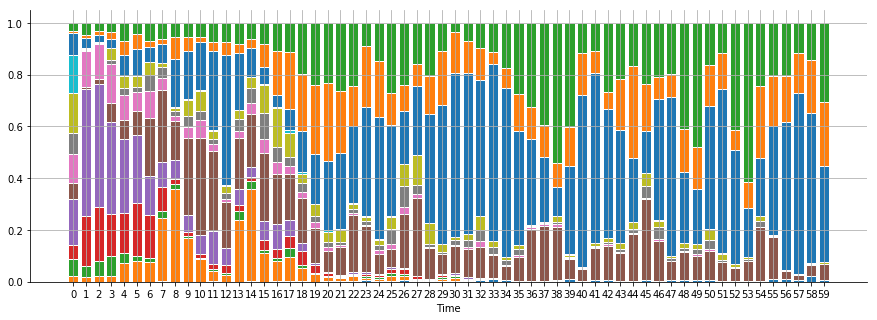

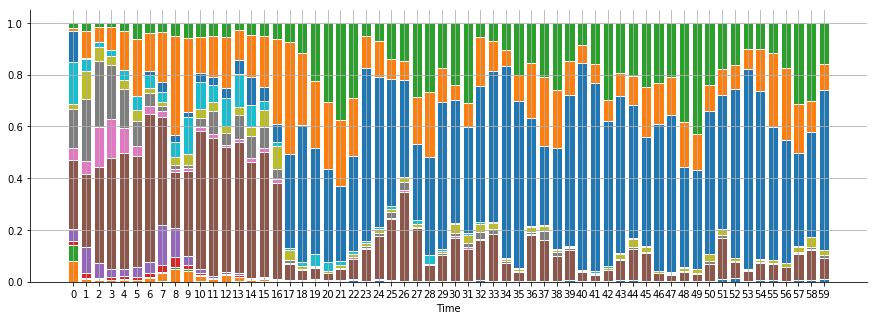

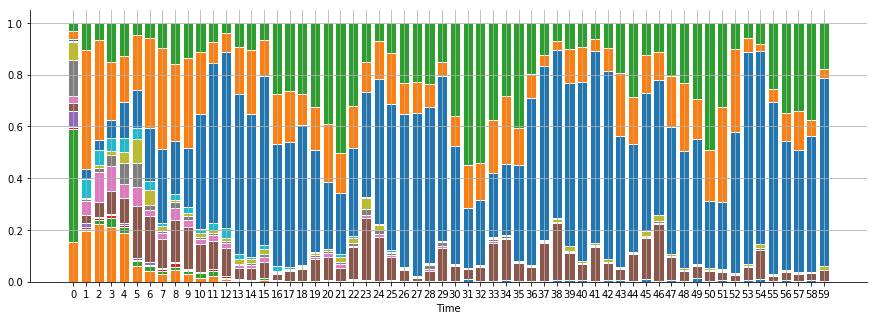

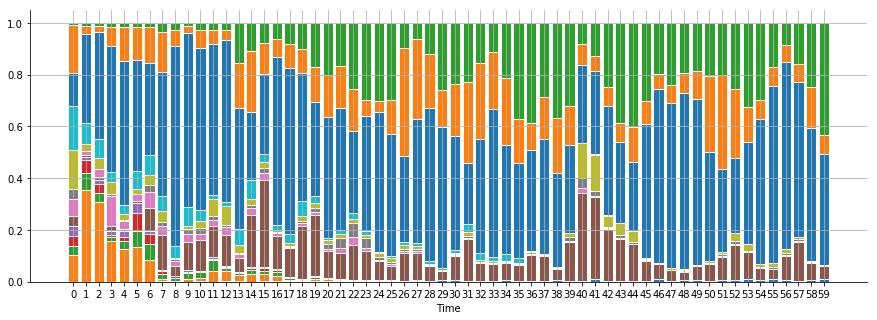

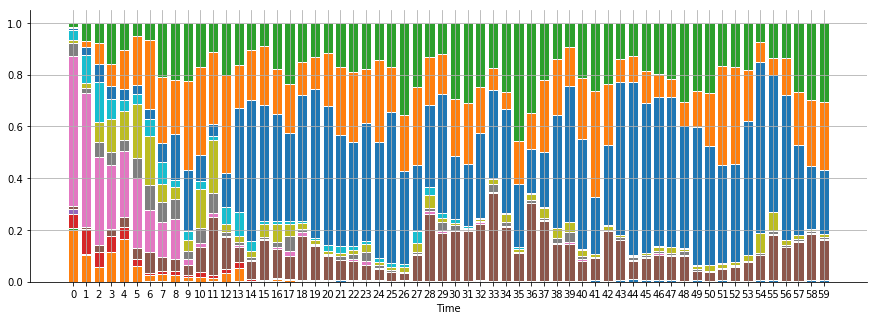

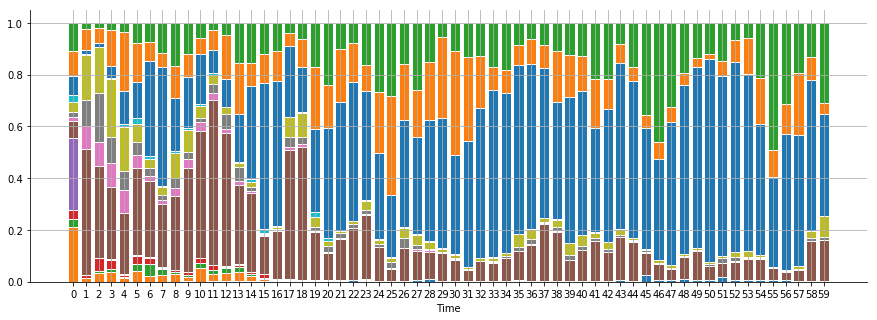

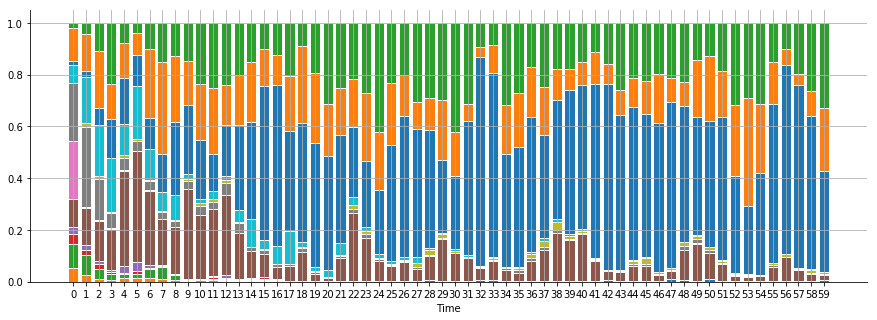

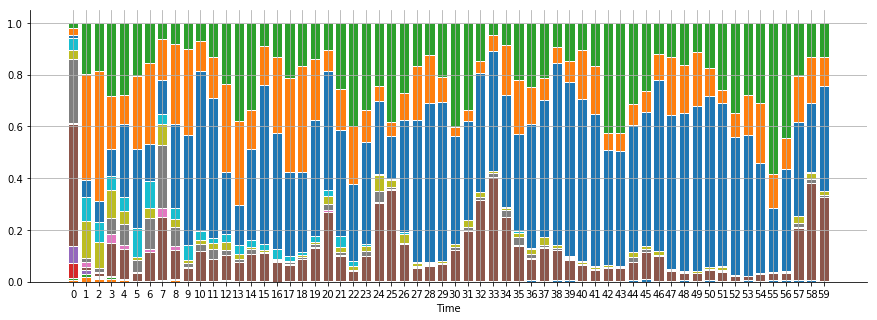

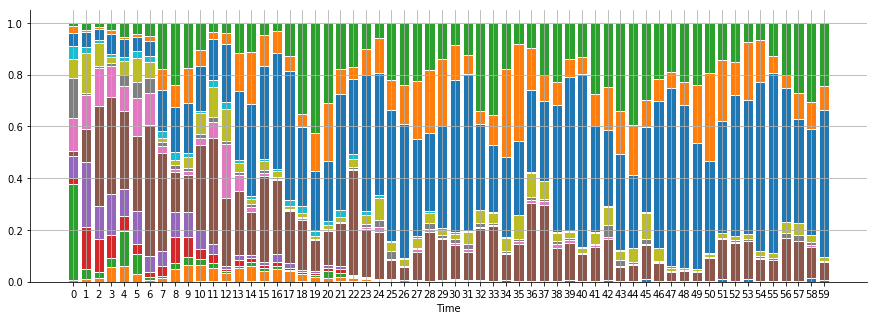

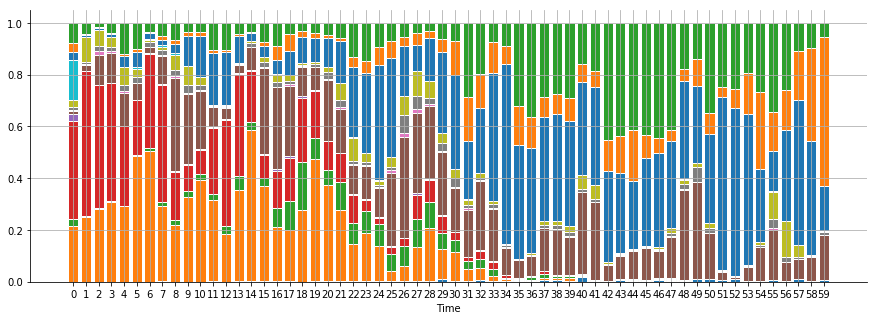

In [14]:
for i in range(10):
    plot_inputs_and_obs(inputs, masks, i)